# TRABAJO PRACTICO N° 1

---


# Aprendizaje Automático 2
### INTEGRANTES: Moresco, Brisa - Cancio, Jose
### AÑO: 2024 - 2º CUAT.

---



# PROBLEMA 1 - MODELO DE REGRESION LINEAL CON REDES NEURONALES

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

Establecer GPU por defecto en caso de estar disponible

In [69]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [70]:
### IMPORTAR LOS DATOS DEL ARCHIVO CSV COMO DATAFRAME DE PANDAS

file_path = "/content/Student_Performance.csv"
df = pd.read_csv(file_path, sep=',')

***INFORMACIÓN DEL DATASET***

El dataset proporcionado incluye las siguientes variables para cada estudiante:

**Hours Studied:** El número total de horas dedicadas al estudio por cada estudiante.

**Previous Scores:** Las puntuaciones obtenidas por los estudiantes en exámenes previos.

**Extracurricular Activities:** Si el estudiante participa en actividades extracurriculares (Sí o No).

**Sleep Hours:** El número promedio de horas de sueño que el estudiante tuvo por día.

**Sample Question Papers Practiced:** El número de cuestionarios de muestra que el estudiante practicó.


Además, el dataset incluye la variable objetivo:

**Performance Index:** Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.



In [71]:
### VISTA DE LOS PRIMEROS 5 REGISTROS
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [72]:
## FORMATO DEL DATASET
df.shape  ## VEMOS QUE CONTIENE 10000 OBSERVACIONES

(10000, 6)

In [73]:
## INFO DEL DATASET(COLUMNAS DATOS, TIPO DATOS, CANTIDAD VALORES NO NULOS, ETC )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [74]:
## COLUMNAS, ¿cuáles son variables numéricas y cuales variables categóricas?
num_var = [variable for variable in df.columns if df[variable].dtype != ('O') ]
cat_var = [variable for variable in df.columns if df[variable].dtype == ('O')]

print(f"La variables numericas en los datos son: {num_var}.\n")
print(f"La variables categoricas en los datos son: {cat_var}.")

La variables numericas en los datos son: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'].

La variables categoricas en los datos son: ['Extracurricular Activities'].


In [75]:
## VEMOS LA CANTIDAD DE VALORES UNICOS DE CADA VARIABLE
df.nunique()

,0
Hours Studied,9
Previous Scores,60
Extracurricular Activities,2
Sleep Hours,6
Sample Question Papers Practiced,10
Performance Index,91


In [76]:
## Observamos los unicos valores en cada una de las variables categoricas

for variable in cat_var:
    print(f"Los unicos valores en {variable} son {df[variable].unique()} (total de {df[variable].nunique()}).\n")


Los unicos valores en Extracurricular Activities son ['Yes' 'No'] (total de 2).



### Datos faltantes

In [77]:
### Cantidad de valores faltantes.

df.isna().sum()

,0
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0
Performance Index,0


* No se verifica la existencia de valores nulos



### Verificar existencia de Datos Duplicados

In [78]:
## EXISTENCIA DE DATOS DUPLICADOS
duplicados = df[df.duplicated()]
duplicados

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
915,9,52,No,5,9,48.0
1477,7,61,Yes,6,8,54.0
1601,5,99,No,7,5,89.0
1786,2,62,Yes,9,4,40.0
2026,5,87,Yes,6,7,74.0
...,...,...,...,...,...,...
9644,4,91,Yes,4,3,71.0
9940,8,95,No,5,2,90.0
9954,6,97,No,8,7,92.0
9966,1,41,No,7,3,12.0


***EXISTEN 127 REGISTROS CON DATOS DUPLICADOS: que pueden corresponder a mismos estudiantes o estudiantes con los mismos datos en cada columna***

In [79]:
# Observamos 2 de los registros duplicados
df[(df['Hours Studied'] == 9) & (df['Previous Scores'] ==52) & (df['Extracurricular Activities'] == 'No') & (df['Sleep Hours'] == 5) & (df['Sample Question Papers Practiced'] == 9)]

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
202,9,52,No,5,9,48.0
915,9,52,No,5,9,48.0


***Los registros duplicados representan el 1.27% de los datos, asi que decidimos eliminarlos***

In [80]:
df.drop_duplicates(inplace=True)

In [81]:
df.duplicated().sum()

0

## Variables Descripcion


In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hours Studied,9873.0,4.992100,2.589081,1.0,3.0,5.0,7.0,9.0
Previous Scores,9873.0,69.441102,17.325601,40.0,54.0,69.0,85.0,99.0
Sleep Hours,9873.0,6.531652,1.697683,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,9873.0,4.583004,2.867202,0.0,2.0,5.0,7.0,9.0
Performance Index,9873.0,55.216651,19.208570,10.0,40.0,55.0,70.0,100.0


* Se puede evidenciar el rango de las variables, por ejemplo 'Sleep Hours' va de 4 a 9 horas con una mediana de 7 horas. El promedio de 'Hours Studied' es de casi 5 horas. El promedio del numero de cuestionarios de muestra ('Sample Question Papers Practiced`) que practicaron es de 4.58 con un desvio de 2.87

### Visualizamos la distribucion de las variables numericas

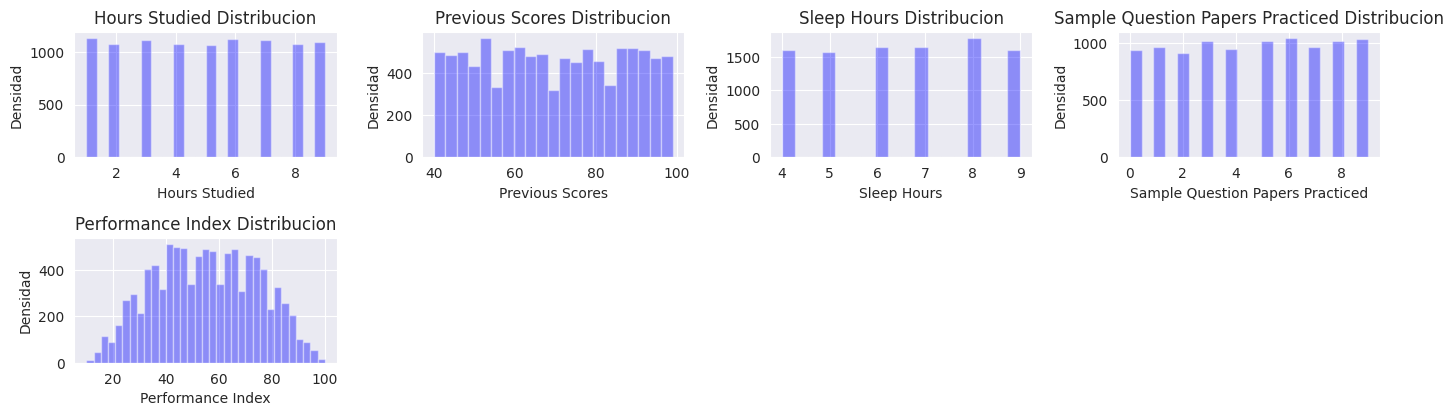

In [83]:
sns.set_style('darkgrid')
plt.figure(figsize=(14,10))
for index, variable in enumerate(num_var):
    plt.subplot(5,4,index+1)
    sns.distplot(df[variable],kde=False, color='b')
    plt.xlabel(variable)
    plt.ylabel('Densidad')
    plt.title(f"{variable} Distribucion")

plt.tight_layout()

* Observamos que para las variables discretas 'Hours Studied', 'Sleep Hours' y	'Sample Question Papers Practiced', sus distribuciones son bastante uniformes, respecto a la cantidad de observaciones para cada valor de las variables. 'Sleep Hours' presenta una moda igual a 8. Las distribuciones no presentan sesgos a izquierda o derecha. La distribucion de la variable 'Performance Index' es de tipo acampanada.


## Visualizamos la distribucion de las variables categoricas

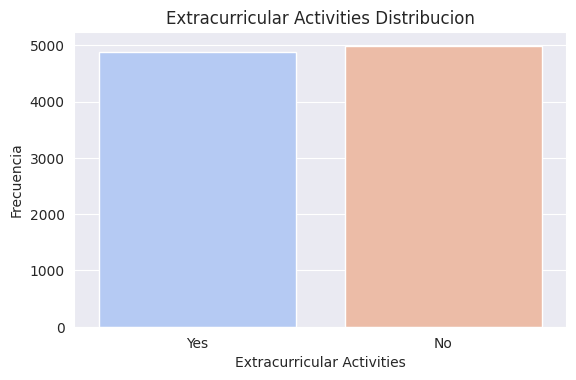

In [84]:
sns.set_style('darkgrid')
plt.figure(figsize=(16,7))
for index, variable in enumerate(cat_var):
    plt.subplot(2,3,index+1)
    sns.countplot(x=variable,data=df,palette='coolwarm')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    plt.title(f"{variable} Distribucion")

plt.tight_layout()

In [85]:
df['Extracurricular Activities'].value_counts()

,count
Extracurricular Activities,
No,4986
Yes,4887


### Codificar los valores de las variables

In [86]:
df[cat_var]

,Extracurricular Activities
0,Yes
1,No
2,Yes
3,Yes
4,No
...,...
9995,Yes
9996,Yes
9997,Yes
9998,Yes


In [87]:
categorico = df.select_dtypes(include = "object").columns
for i in range(len(categorico)):
    df[categorico[i]] = LabelEncoder().fit_transform(df[categorico[i]])

In [88]:
# VEMOS COMO QUEDARON CODIFICADAS LAS VARIABLES CATEGORICAS
df[cat_var]

,Extracurricular Activities
0,1
1,0
2,1
3,1
4,0
...,...
9995,1
9996,1
9997,1
9998,1


## Verificamos la presencia de valores atipicos

Realizamos un gráfico Boxplot para visualizar la distribución de los valores de las variables.

Debido a los valores numericos mas altos de las variables 'Previous Score' y  'Performance Index' respecto del resto, se grafican aparte, para visualizar mejor el grafico del resto.

In [89]:
columnas = [col for col in df.columns if ((col != 'Previous Scores') & (col != 'Performance Index'))]

In [90]:
columnas

['Hours Studied',
 'Extracurricular Activities',
 'Sleep Hours',
 'Sample Question Papers Practiced']

<Axes: >

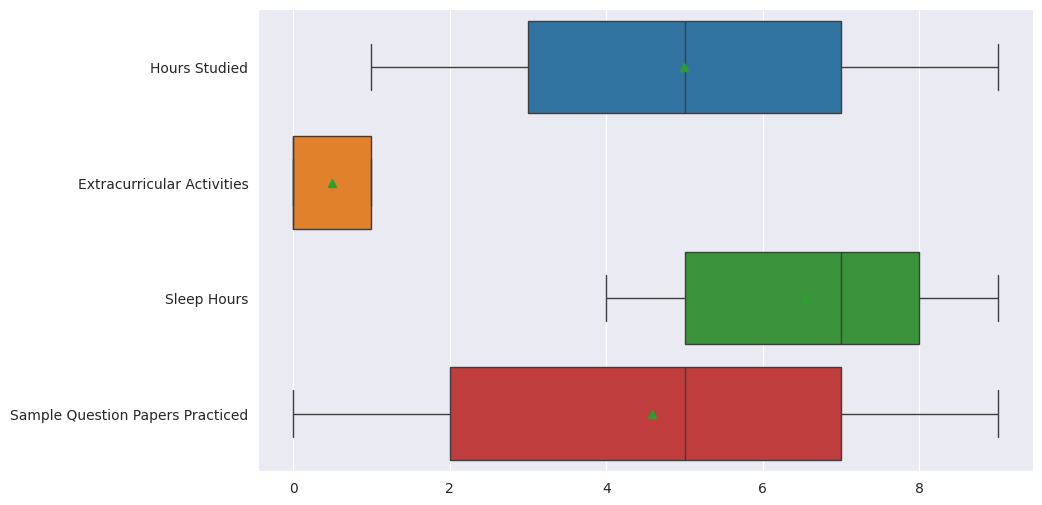

In [91]:
plt.figure(figsize= (10,6))
sns.boxplot(df[columnas], orient= 'h', showmeans= True)

<Axes: >

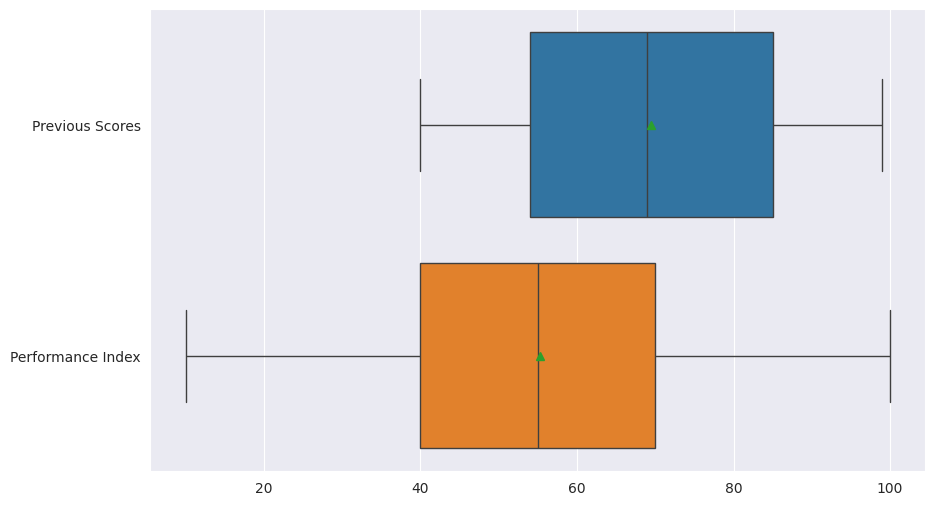

In [92]:
plt.figure(figsize= (10,6))
sns.boxplot(df[['Previous Scores', 'Performance Index']], orient= 'h', showmeans= True)

* No se observan valores atípicos

### Matriz de Correlacion

In [93]:
corr = df.corr(numeric_only=True)
corr

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
Hours Studied,1.000000,-0.010676,0.004899,0.002131,0.015740,0.375332
Previous Scores,-0.010676,1.000000,0.009534,0.007975,0.008719,0.915135
Extracurricular Activities,0.004899,0.009534,1.000000,-0.024008,0.013839,0.026075
Sleep Hours,0.002131,0.007975,-0.024008,1.000000,0.004907,0.050352
Sample Question Papers Practiced,0.015740,0.008719,0.013839,0.004907,1.000000,0.043436
Performance Index,0.375332,0.915135,0.026075,0.050352,0.043436,1.000000


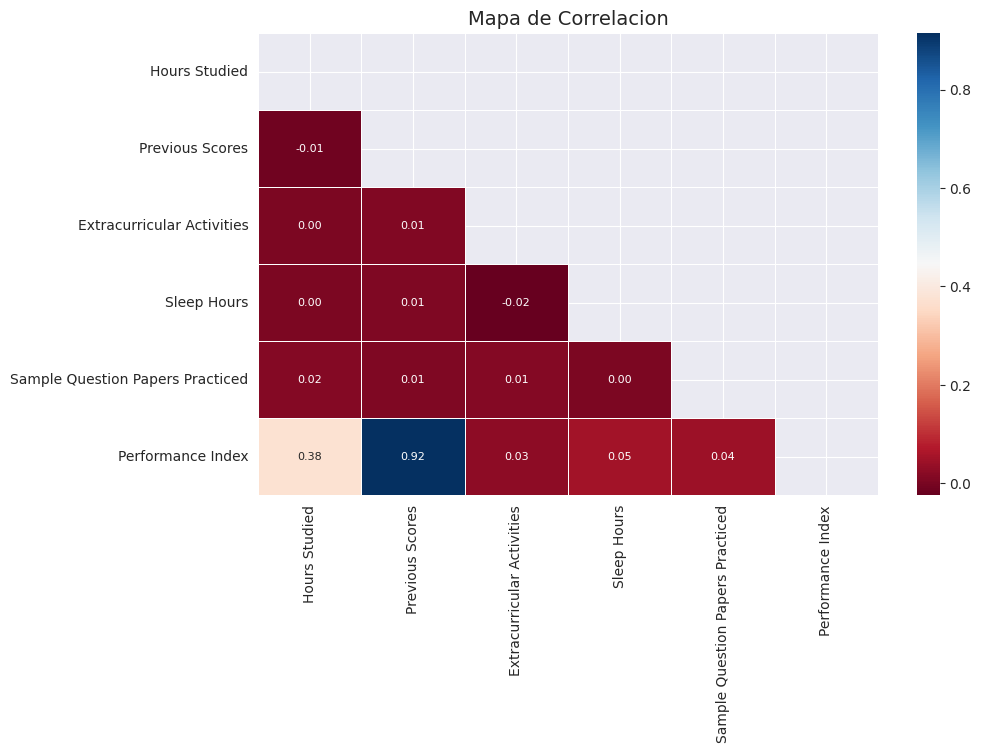

In [94]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Mapa de Correlacion", fontsize=14)
mask = np.triu(np.ones_like(corr, dtype=bool)) # MASCARA PARA GRAFICAR SOLO UN TRIANGULO DE LA MATRIZ DE CORRELACION
# Genera el heatmap incluyendo la mascara mask
heatmap = sns.heatmap(corr,
                      annot=True,
                      annot_kws={"fontsize": 8},
                      fmt='.2f',
                      linewidths=0.5,
                      cmap='RdBu',
                      mask=mask, # la mascara ha sido incluida aqui
                      ax=ax)

plt.show()

Las variables que presentan la correlacion lineal mas alta con 'Performance Index' son:



*   **Previous Scores: + 0.92**
*   **Hours Studied: + 0.37**


El resto de las variables presentan una correlacion lineal casi nula con 'Performance Index':




### Estandarizamos el Dataset

In [95]:
# ESTANDARIZAMOS LAS VARIABLES DEL DATASET

# Crea un objeto StandardScaler
scaler = StandardScaler()

# Ajusta el scaler a los datos y transfórmalos
df_scaled = scaler.fit_transform(df)

# Crea un nuevo DataFrame con los datos escalados
df_scaled = pd.DataFrame(df_scaled,columns=df.columns)
df_scaled

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,0.775566,1.706168,1.010078,1.454025,-1.249715,1.862979
1,-0.383205,0.724912,-0.990022,-1.491315,-0.900925,0.509348
2,1.161822,-1.064438,1.010078,0.275889,-0.900925,-0.531907
3,0.003052,-1.006717,1.010078,-0.902247,-0.900925,-1.000471
4,0.775566,0.320865,-0.990022,0.864957,0.145444,0.561411
...,...,...,...,...,...,...
9868,-1.541976,-1.179880,1.010078,-1.491315,-0.900925,-1.677287
9869,0.775566,-0.314066,1.010078,0.864957,0.145444,0.144909
9870,0.389309,0.782633,1.010078,0.864957,0.145444,0.977912
9871,1.548079,1.590727,1.010078,0.275889,-1.598505,2.071230


## Split del Dataset

In [96]:
# División de los datos en train y test

X = df_scaled.drop(columns= ['Performance Index'])
y = df_scaled['Performance Index']

X_train, X_test, y_train, y_test = train_test_split(X,y.values.reshape(-1,1),test_size=0.2,random_state = 42, shuffle= False)

In [97]:
X_train.shape, X_test.shape

((7898, 5), (1975, 5))

In [98]:
y_train.shape, y_test.shape

((7898, 1), (1975, 1))

In [99]:
X_train.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced'],
      dtype='object')

In [100]:
X_train

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
0,0.775566,1.706168,1.010078,1.454025,-1.249715
1,-0.383205,0.724912,-0.990022,-1.491315,-0.900925
2,1.161822,-1.064438,1.010078,0.275889,-0.900925
3,0.003052,-1.006717,1.010078,-0.902247,-0.900925
4,0.775566,0.320865,-0.990022,0.864957,0.145444
...,...,...,...,...,...
7893,-1.155719,-1.468485,-0.990022,0.864957,-1.598505
7894,-0.769462,0.263144,1.010078,0.864957,-0.203346
7895,1.161822,-0.660392,-0.990022,-0.902247,-0.552136
7896,1.161822,1.417564,-0.990022,-0.313179,-1.249715


In [101]:
 # Convert X_train and y_train to NumPy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [102]:
X_train.shape, X_test.shape

((7898, 5), (1975, 5))

### **MODELO REGRESION CON RED NEURONAL**

*A continuación, experimentaremos con modelos de regresion utilizando redes neuronales.*

In [59]:
EPOCHS= 60

In [156]:
# Definir la arquitectura del modelo con 1 capa oculta de 32 neuronas
def create_model():
    model = tf.keras.models.Sequential(name="NN_1_capa_32")  # Nombre del modelo)
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(1))  # Salida para regresión
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'r2_score'])
    return model



Fold 1

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - mae: 0.0906 - r2_score: 0.9879


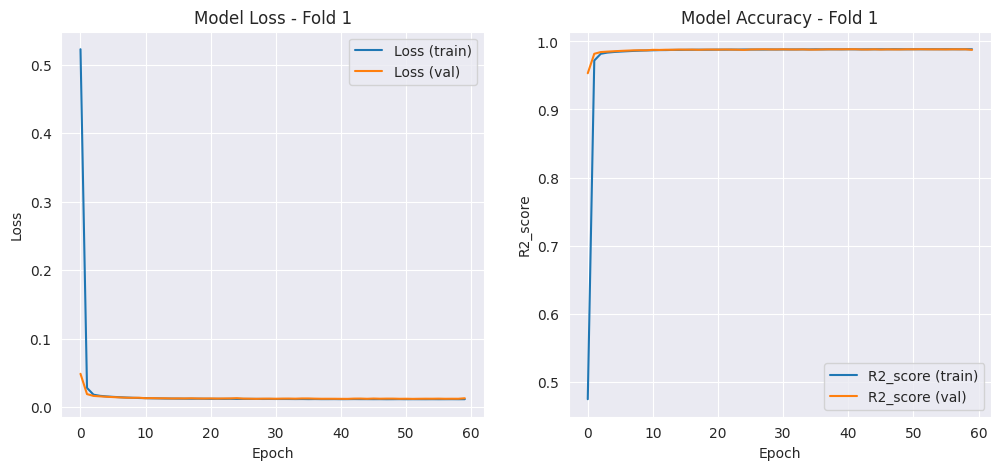


Fold 2

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - mae: 0.0874 - r2_score: 0.9879


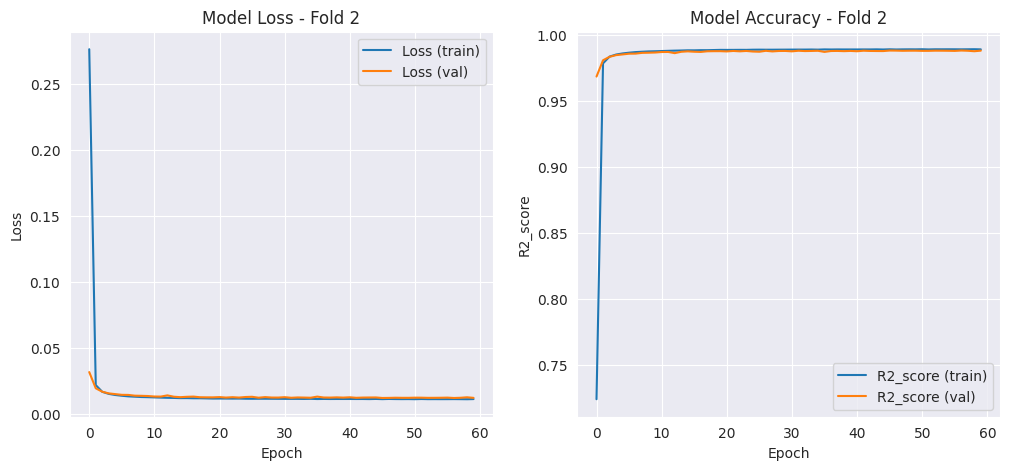


Fold 3

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124 - mae: 0.0886 - r2_score: 0.9872


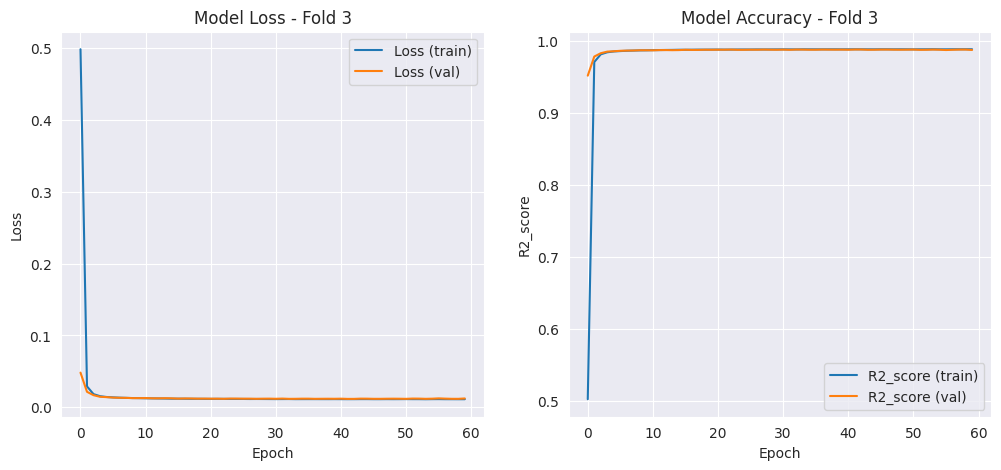


Fold 4

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - mae: 0.0855 - r2_score: 0.9879


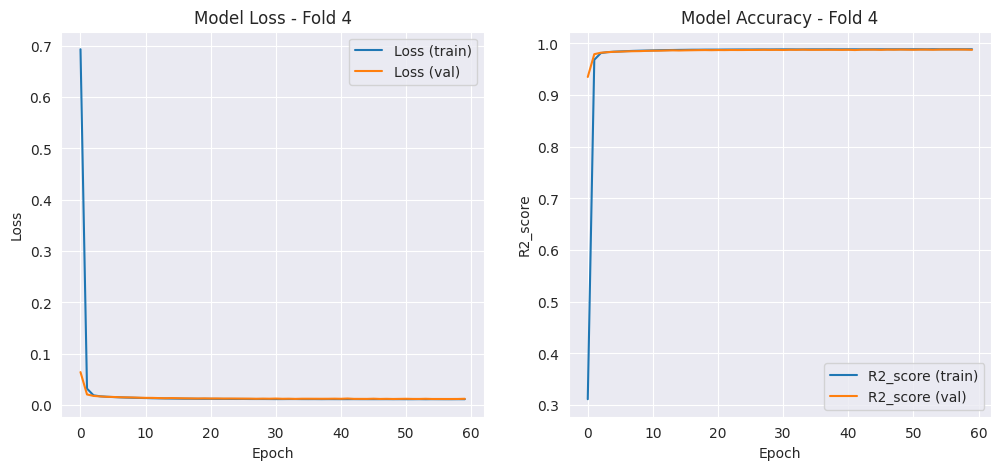


Fold 5



Model: "NN_1_capa_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)                    │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - mae: 0.0878 - r2_score: 0.9880


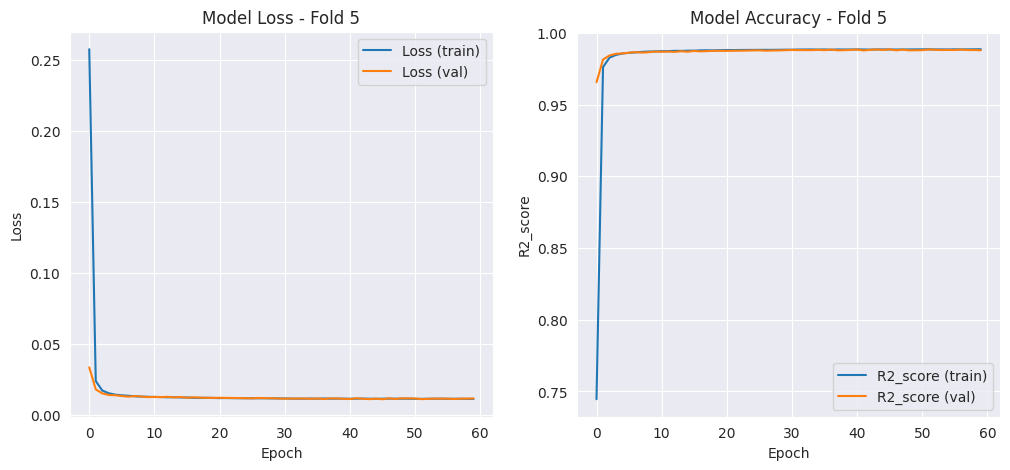

Average Loss: 0.012256981246173382
Average MAE: 0.08817703425884246
Average R2_score: 0.9877764463424683


In [129]:
from sklearn.model_selection import KFold

# Configuración de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # shuffle para mezclar los datos
losses = []
maes = []
accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'\nFold {fold + 1}\n')

    # Dividir el conjunto de datos en entrenamiento y validación
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

    # Crear un modelo
    # model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(tf.keras.layers.Dense(1))  # Salida para regresión
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    # model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'r2_score'])
    model = create_model()

    # Mostramos la estructura de la red neuronal solo en el ultimo fold
    if fold == 4:
      model.summary()

    # Entrenar el modelo
    history = model.fit(X_train_kf, y_train_kf,
                        validation_data=(X_val_kf, y_val_kf),  # Conjunto de validación
                        epochs=EPOCHS,
                        batch_size=32,
                        verbose=0)

    # Almacenar las métricas finales
    loss, mae, r2_score = model.evaluate(X_val_kf, y_val_kf)
    losses.append(loss)
    maes.append(mae)
    accuracies.append(r2_score)

    # Graficar las métricas de pérdida y precisión para el pliegue actual
    plt.figure(figsize=(12, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss (train)')
    plt.plot(history.history['val_loss'], label='Loss (val)')
    plt.title(f'Model Loss - Fold {fold + 1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # R2_score
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='R2_score (train)')
    plt.plot(history.history['val_r2_score'], label='R2_score (val)')
    plt.title(f'Model Accuracy - Fold {fold + 1}')
    plt.ylabel('R2_score')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

# Resultados finales
print(f'Average Loss: {np.mean(losses)}')
print(f'Average MAE: {np.mean(maes)}')
print(f'Average R2_score: {np.mean(accuracies)}')


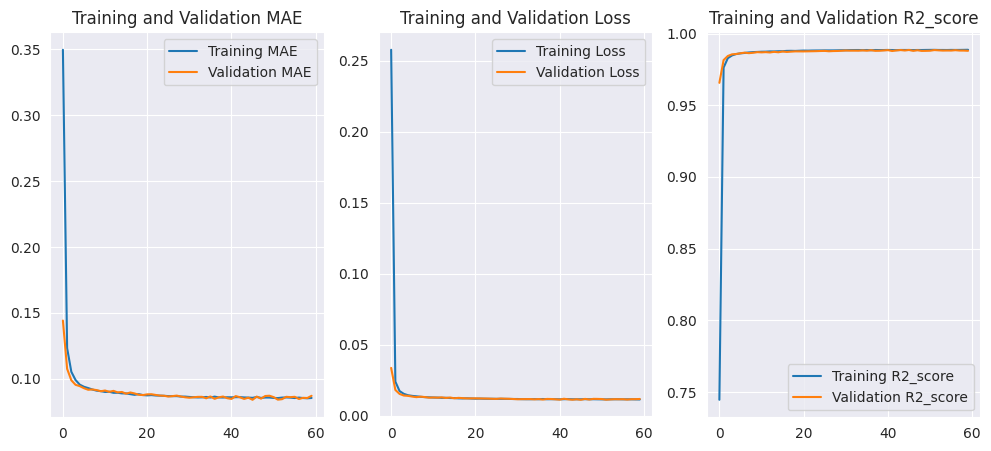

In [148]:
# Grafica la precisión, MAE y pérdida de entrenamiento y validación
mae = history.history['mae']
R2_score = history.history['r2_score']
val_mae = history.history['val_mae']
val_R2 = history.history['val_r2_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, R2_score, label='Training R2_score')
plt.plot(epochs_range, val_R2, label='Validation R2_score')
plt.legend(loc='lower right')
plt.title('Training and Validation R2_score')
plt.show()

In [ ]:
# MISMO MODELO ANTERIOR PERO CON CONJUNTO DE VALIDACION EN EL PROCESO DE ENTRENAMIENTO (FIT)

In [157]:
model_2 = create_model()

In [158]:
model_2.summary()

Model: "NN_1_capa_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_113 (Dense)                    │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [160]:
# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train,
                        validation_split= 0.2,  # Porcentaje conjunto de validación
                        epochs=EPOCHS,
                        batch_size=32,
                        verbose=1)

Epoch 1/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7206 - mae: 0.6906 - r2_score: 0.2550 - val_loss: 0.0423 - val_mae: 0.1643 - val_r2_score: 0.9597
Epoch 2/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - mae: 0.1327 - r2_score: 0.9713 - val_loss: 0.0168 - val_mae: 0.1031 - val_r2_score: 0.9840
Epoch 3/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - mae: 0.1033 - r2_score: 0.9835 - val_loss: 0.0148 - val_mae: 0.0963 - val_r2_score: 0.9858
Epoch 4/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - mae: 0.0956 - r2_score: 0.9854 - val_loss: 0.0143 - val_mae: 0.0945 - val_r2_score: 0.9864
Epoch 5/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - mae: 0.0941 - r2_score: 0.9860 - val_loss: 0.0139 - val_mae: 0.0931 - val_r2_score: 0.9868
Epoch 6/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142 - mae: 0.0949 - r2_score: 0.9855 - val_loss: 0.0136 - val_mae: 0.0917 - val_r2_score: 0.9871
Epoch 7/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 

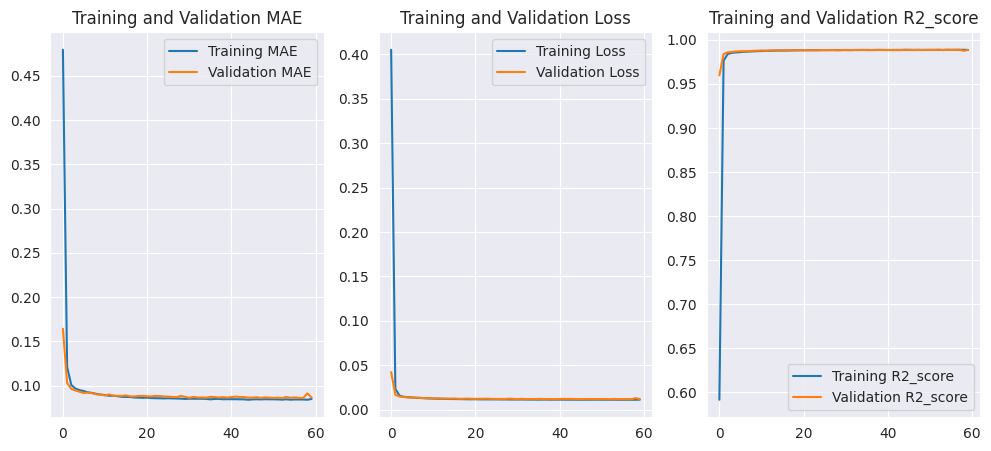

In [161]:
# Grafica la precisión, MAE y pérdida de entrenamiento y validación
mae = history_2.history['mae']
R2_score = history_2.history['r2_score']
val_mae = history_2.history['val_mae']
val_R2 = history_2.history['val_r2_score']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, R2_score, label='Training R2_score')
plt.plot(epochs_range, val_R2, label='Validation R2_score')
plt.legend(loc='lower right')
plt.title('Training and Validation R2_score')
plt.show()

* Otra red con mas neuronas

In [ ]:
EPOCHS= 60

In [166]:
# Definir la arquitectura del modelo con 2 capas ocultas de 32 neuronas cada una
def create_model_2():
    model = tf.keras.models.Sequential(name="NN_2_capa_32")  # Nombre del modelo)
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # Salida para regresión
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'r2_score'])
    return model


In [167]:
model_3 = create_model_2()

In [168]:
model_3.summary()

Model: "NN_2_capa_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)                    │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
# Entrenar el modelo con valicacion
history_3 = model_3.fit(X_train, y_train,
                        validation_split= 0.2,  # Porcentaje conjunto de validación
                        epochs=EPOCHS,
                        batch_size=32,
                        verbose=1)

Epoch 1/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3377 - mae: 0.4095 - r2_score: 0.6461 - val_loss: 0.0178 - val_mae: 0.1063 - val_r2_score: 0.9831
Epoch 2/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - mae: 0.1004 - r2_score: 0.9835 - val_loss: 0.0147 - val_mae: 0.0971 - val_r2_score: 0.9860
Epoch 3/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - mae: 0.0931 - r2_score: 0.9859 - val_loss: 0.0137 - val_mae: 0.0927 - val_r2_score: 0.9870
Epoch 4/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - mae: 0.0894 - r2_score: 0.9871 - val_loss: 0.0137 - val_mae: 0.0926 - val_r2_score: 0.9870
Epoch 5/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - mae: 0.0889 - r2_score: 0.9875 - val_loss: 0.0135 - val_mae: 0.0920 - val_r2_score: 0.9871
Epoch 6/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - mae: 0.0889 - r2_score: 0.9873 - val_loss: 0.0137 - val_mae: 0.0931 - val_r2_score: 0.9870
Epoch 7/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 

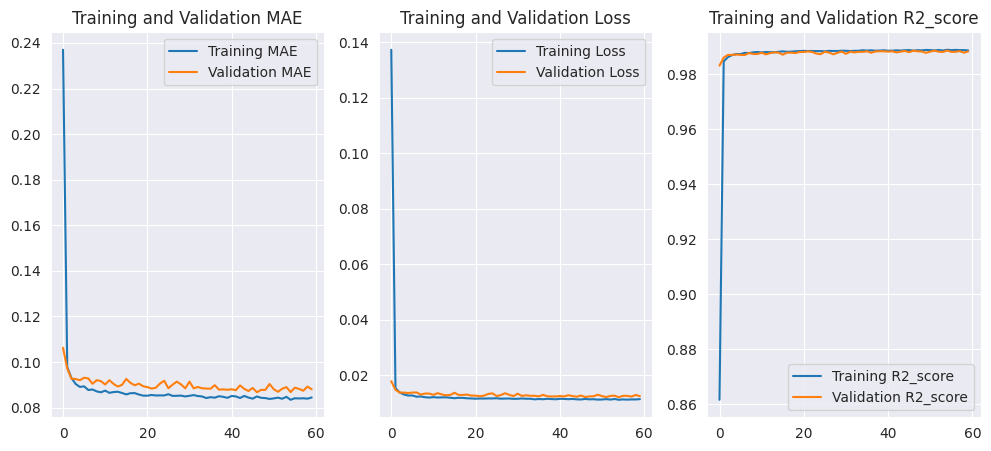

In [170]:
# Grafica la precisión, MAE y pérdida de entrenamiento y validación
mae = history_3.history['mae']
R2_score = history_3.history['r2_score']
val_mae = history_3.history['val_mae']
val_R2 = history_3.history['val_r2_score']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, R2_score, label='Training R2_score')
plt.plot(epochs_range, val_R2, label='Validation R2_score')
plt.legend(loc='lower right')
plt.title('Training and Validation R2_score')
plt.show()

## **CARACTERISTICAS MAS IMPORTANTES**
### De acuerdo a la matriz de correlacion vista anteriormente, vimos que las variables 'Previous Scores'(+ 0.92) y 'Hours Studied'(+ 0.37) son las que tienen la mayor correlacion con la variable objetivo 'Performance Index' y el resto casi nulas. Por lo tanto, vamos a entrenar un modelo que contenga unicamente a estas 2 variables como variables de entrada y observar los resultados obtenidos


In [197]:
columnas = ['Previous Scores', 'Hours Studied', 'Performance Index']

In [219]:
df_2 = df_scaled[columnas]
df_2

,Previous Scores,Hours Studied,Performance Index
0,1.706168,0.775566,1.862979
1,0.724912,-0.383205,0.509348
2,-1.064438,1.161822,-0.531907
3,-1.006717,0.003052,-1.000471
4,0.320865,0.775566,0.561411
...,...,...,...
9868,-1.179880,-1.541976,-1.677287
9869,-0.314066,0.775566,0.144909
9870,0.782633,0.389309,0.977912
9871,1.590727,1.548079,2.071230


In [220]:
# División de los datos en train y test

X = df_2.drop(columns= ['Performance Index'])
y = df_2['Performance Index']

X_train, X_test, y_train, y_test = train_test_split(X,y.values.reshape(-1,1),test_size=0.2,random_state = 42, shuffle= False)

In [222]:
 # Convert X_train and y_train to NumPy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [218]:
y_train.shape, y_test.shape

((7898, 1), (1975, 1))

In [209]:
X_train.columns

Index(['Previous Scores', 'Hours Studied'], dtype='object')

In [244]:
model_4= create_model()
model_4.summary()

Model: "NN_1_capa_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)                    │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

* Observamos, como era de esperar,  que al ser menor la cantidad de variables de entrada, el total de parametros del modelo tambien es menor

In [245]:
EPOCHS= 30
history_4 = model_4.fit(X_train, y_train,
                        validation_split= 0.2,  # Split para conjunto de validación
                        epochs=EPOCHS,
                        batch_size=32,
                        verbose=1)

Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8931 - mae: 0.7743 - r2_score: 0.0960 - val_loss: 0.0373 - val_mae: 0.1535 - val_r2_score: 0.9644
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0258 - mae: 0.1267 - r2_score: 0.9737 - val_loss: 0.0208 - val_mae: 0.1152 - val_r2_score: 0.9802
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0203 - mae: 0.1138 - r2_score: 0.9794 - val_loss: 0.0195 - val_mae: 0.1113 - val_r2_score: 0.9815
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - mae: 0.1088 - r2_score: 0.9810 - val_loss: 0.0182 - val_mae: 0.1076 - val_r2_score: 0.9826
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - mae: 0.1068 - r2_score: 0.9824 - val_loss: 0.0175 - val_mae: 0.1052 - val_r2_score: 0.9833
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - mae: 0.1041 - r2_score: 0.9830 - val_loss: 0.0166 - val_mae: 0.1023 - val_r2_score: 0.9842
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 

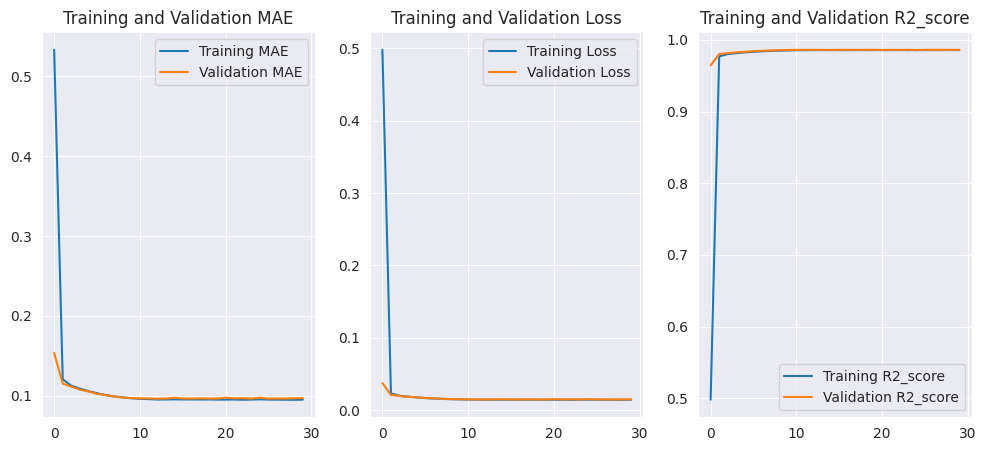

In [246]:
# Grafica la precisión, MAE y pérdida de entrenamiento y validación
mae = history_4.history['mae']
R2_score = history_4.history['r2_score']
val_mae = history_4.history['val_mae']
val_R2 = history_4.history['val_r2_score']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, R2_score, label='Training R2_score')
plt.plot(epochs_range, val_R2, label='Validation R2_score')
plt.legend(loc='lower right')
plt.title('Training and Validation R2_score')
plt.show()

### Realizar predicciones sobre conjuntos de train y test
* Nos quedamos con el ultimo modelo entrenado

In [251]:
# Predicciones
y_pred_train = model_4.predict(X_train)
y_pred_test = model_4.predict(X_test)

y_pred_train.shape, y_pred_test.shape

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


((7898, 1), (1975, 1))

### Calcular metricas sobre el conjunto de train

In [253]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared = False) # Se usa el rmse para mantener la misma escala que la variable a predecir
R2_train = metrics.r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)


### Calcular metricas sobre el conjunto de test

In [254]:
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False) # Se usa el rmse para mantener la misma escala que la variable a predeci
R2_test = metrics.r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)


### Visualizamos las metricas

In [255]:
print('Metricas sobre el conjunto de train')
print(' Error cuadratico medio (MSE) Train: ', rmse_train)
print(' R cuadrado (R2) Train: ', R2_train)
print(' Error absoluto medio (MAE) Train: ', mae_train)

print('\nMetricas sobre el conjunto de test')
print(' Error cuadratico medio (MSE) Test: ', rmse_test)
print(' R cuadrado (R2) Test: ', R2_test)
print(' Error absoluto medio (MAE) Test: ', mae_test)

Metricas sobre el conjunto de train
 Error cuadratico medio (MSE) Train:  0.11957455980996617
 R cuadrado (R2) Train:  0.9857508798094868
 Error absoluto medio (MAE) Train:  0.09540764305752729

Metricas sobre el conjunto de test
 Error cuadratico medio (MSE) Test:  0.12240243090771051
 R cuadrado (R2) Test:  0.9848077430795704
 Error absoluto medio (MAE) Test:  0.09693907462755126


### **CONCLUSION:**
* Observamos que los resultados obtenidos por el modelo de regresion sobre el conjunto de datos nunca vistos (X_test) son buenos con un valor de R2_score o coeficiente de determinación de 0.98 que indica la proporción de la variación en la variable dependiente que explica el modelo. El valor del RMSE es igual a 0.1224 (el cual esta en las mismas unidades que la variable objetivo).
* De acuerdo al conjunto de datos de origen, no fue necesaria una mayor complejidad del modelo (con mas capas y neuronas - model_2) para obtener buenos resultados. Inclusive las epocas se fueron bajando desde las 60 iniciales hasta 10 y las metricas siguieron siendo buenas.
* Finalmente, por la correlacion entre las variables de entrada y la variable objetivo ('Performance Index'), se termino trabajando sobre un modelo con solo 2 variables que poseian las mayores correlaciones ('Previous Scores' y 'Hours Studied').
